In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import healpy as hp
import rubin_sim.maf as maf

from rubin_sim.site_models import Almanac
from rubin_sim.scheduler.example import example_scheduler, sched_argparser
from rubin_sim.scheduler.utils import generate_all_sky, EuclidOverlapFootprint, make_rolling_footprints, slice_quad_galactic_cut

In [2]:
nside=32
mjd_start = 60796.0
parser = sched_argparser()
args = parser.parse_args(args=[])
args

Namespace(verbose=False, survey_length=3652.5, outDir='', maxDither=0.7, moon_illum_limit=40.0, nexp=2, rolling_nslice=2, rolling_strength=0.9, dbroot=None, ddf_season_frac=0.2, nights_off=3, neo_night_pattern=4, neo_filters='riz', neo_repeat=4, neo_am=2.5, neo_elong_req=45.0, neo_area_req=0.0, setup_only=False, nside=32)

In [3]:
sky = EuclidOverlapFootprint(nside=args.nside)
footprints_hp_array, labels = sky.return_maps()

wfd_indx = np.where((labels == "lowdust") | (labels == "LMC_SMC") | (labels == "virgo"))[0]
wfd_footprint = footprints_hp_array["r"] * 0
wfd_footprint[wfd_indx] = 1

footprints_hp = {}
for key in footprints_hp_array.dtype.names:
    footprints_hp[key] = footprints_hp_array[key]

footprint_mask = footprints_hp["r"] * 0
footprint_mask[np.where(footprints_hp["r"] > 0)] = 1


# Use the Almanac to find the position of the sun at the start of survey
almanac = Almanac(mjd_start=mjd_start)
sun_moon_info = almanac.get_sun_moon_positions(mjd_start)
sun_ra_start = sun_moon_info["sun_RA"].copy()

footprints = make_rolling_footprints(
    fp_hp=footprints_hp,
    mjd_start=mjd_start,
    sun_ra_start=sun_ra_start,
    nslice=args.rolling_nslice,
    scale=args.rolling_strength,
    nside=args.nside,
    wfd_indx=wfd_indx,
    order_roll=1,
    n_cycles=4,
)

In [4]:
allsky = generate_all_sky(nside=args.nside)
sky = EuclidOverlapFootprint(nside=args.nside)
footprints_hp_array, labels = sky.return_maps()

wfd_indx = np.where((labels == "lowdust") | (labels == "LMC_SMC") | (labels == "virgo"))[0]
wfd_footprint = footprints_hp_array["r"] * 0
wfd_footprint[wfd_indx] = 1

footprints_hp = {}
for key in footprints_hp_array.dtype.names:
    footprints_hp[key] = footprints_hp_array[key]

slice_idxs = slice_quad_galactic_cut(footprints_hp, nslice=args.rolling_nslice, wfd_indx=wfd_indx)

In [5]:
ra_slice = np.where(np.abs(allsky['ra'] - 0) < 5)
both = np.intersect1d(np.array(slice_idxs[0]), ra_slice)
print(allsky['dec'][both])
dec_bands_S = [2.4, -16, -33, -50]

[  2.38801546   2.38801546   1.19374844   1.19374844   0.
   0.          -1.19374844  -1.19374844  -2.38801546  -2.38801546
  -3.5833217   -3.5833217   -4.78019185  -4.78019185  -5.9791568
  -5.9791568   -7.18075578  -7.18075578  -8.38553865  -8.38553865
  -9.59406823  -9.59406823 -10.80692287 -10.80692287 -12.02469918
 -12.02469918 -13.24801491 -13.24801491 -14.47751219 -14.47751219
 -15.71386105 -15.71386105 -32.7971683  -32.7971683  -34.22886633
 -34.22886633 -35.68533471 -35.68533471 -37.16889966 -37.16889966
 -38.68218745 -38.68218745 -40.22818473 -40.22818473 -41.8103149
 -41.8103149  -43.40685849 -43.40685849 -44.99388015 -44.99388015
 -46.57184741 -46.57184741 -48.14120779 -48.14120779 -49.70239033]


In [6]:
ra_slice = np.where(np.abs(allsky['ra'] - 160) < 5)
both = np.intersect1d(np.array(slice_idxs[0]), ra_slice)
print(allsky['dec'][both])
dec_bands_N = [15, 5, -10, -25]

[ 14.47751219  14.47751219  14.47751219  14.47751219  13.24801491
  13.24801491  13.24801491  12.02469918  12.02469918  12.02469918
  12.02469918  10.80692287  10.80692287  10.80692287   9.59406823
   9.59406823   9.59406823   9.59406823   8.38553865   8.38553865
   8.38553865   7.18075578   7.18075578   7.18075578   7.18075578
   5.9791568    5.9791568    5.9791568    4.78019185   4.78019185
   4.78019185   4.78019185  -9.59406823  -9.59406823  -9.59406823
  -9.59406823 -10.80692287 -10.80692287 -10.80692287 -12.02469918
 -12.02469918 -12.02469918 -12.02469918 -13.24801491 -13.24801491
 -13.24801491 -14.47751219 -14.47751219 -14.47751219 -14.47751219
 -15.71386105 -15.71386105 -15.71386105 -16.9577633  -16.9577633
 -16.9577633  -16.9577633  -18.20995686 -18.20995686 -18.20995686
 -19.47122063 -19.47122063 -19.47122063 -19.47122063 -20.74237995
 -20.74237995 -20.74237995 -22.02431284 -22.02431284 -22.02431284
 -22.02431284 -23.31795707 -23.31795707 -23.31795707 -24.62431835
 -24.624318

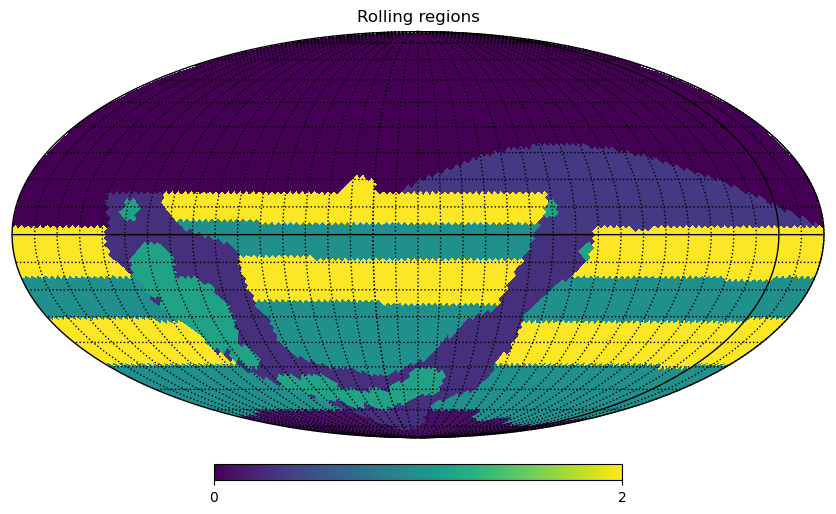

In [7]:
split = np.zeros(len(footprints_hp['r']))
split[slice_idxs[0]] = 1
#split[slice_idxs[1]] = 1
split += footprints_hp['r']
hp.mollview(split, title="Rolling regions", rot=(160, 0, 0))
hp.graticule(dpar=10)

In [8]:
def sum_all_filters(maps):
    total = np.zeros(hp.nside2npix(nside), float)
    for f in 'ugrizy':
        total += maps[f]
    return total

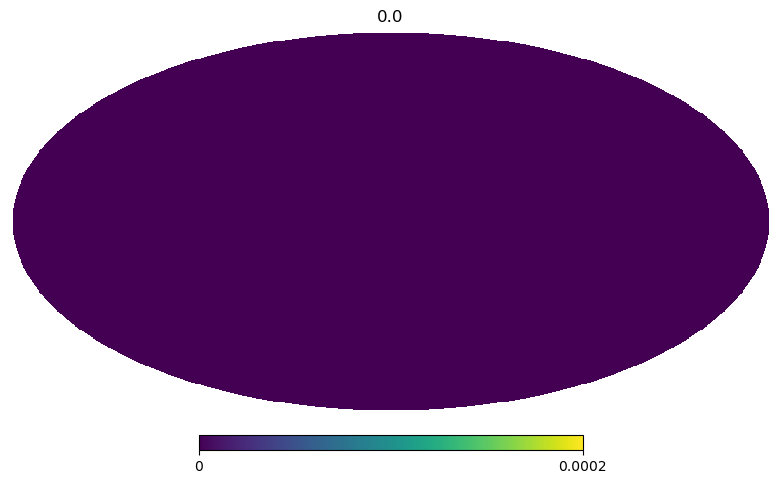

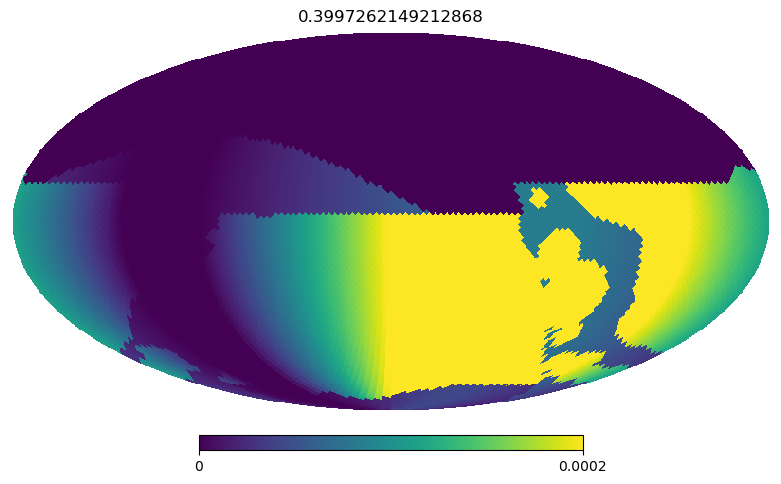

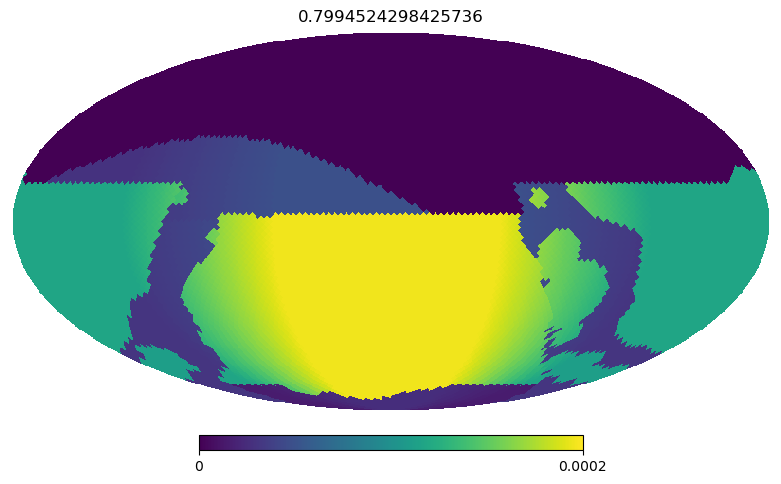

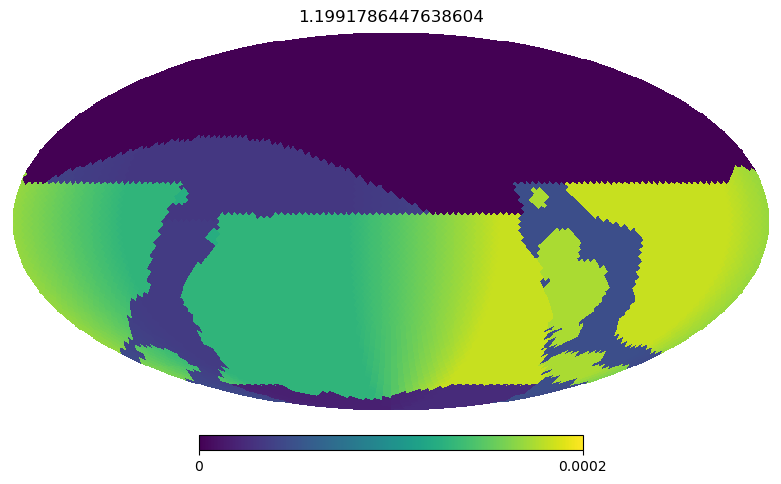

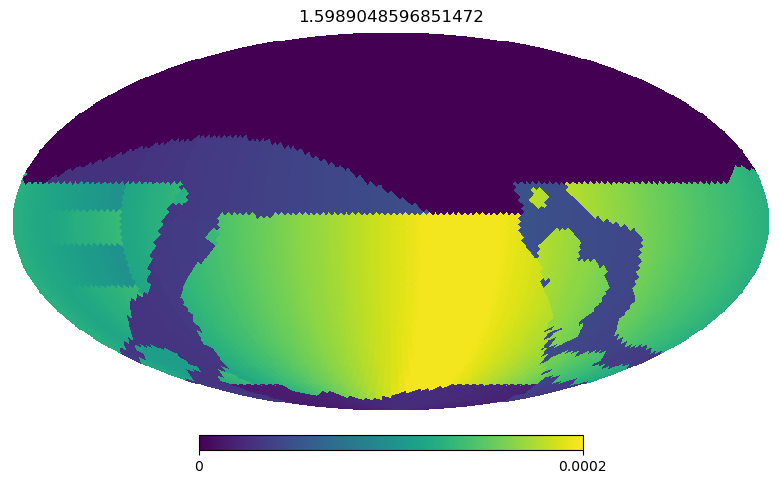

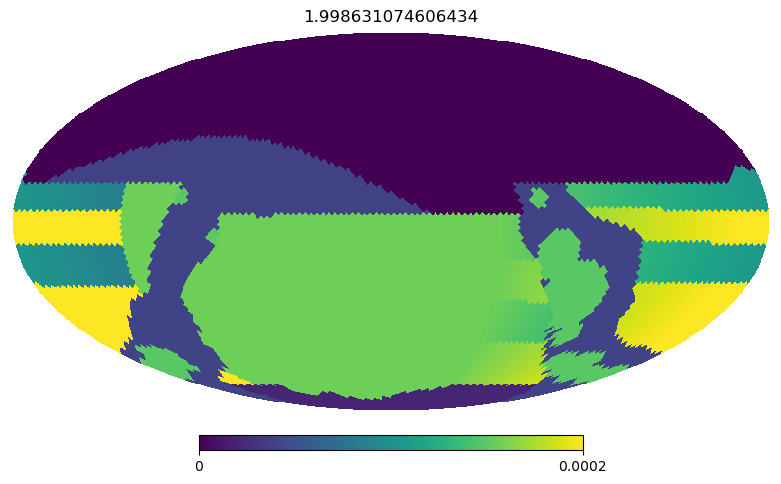

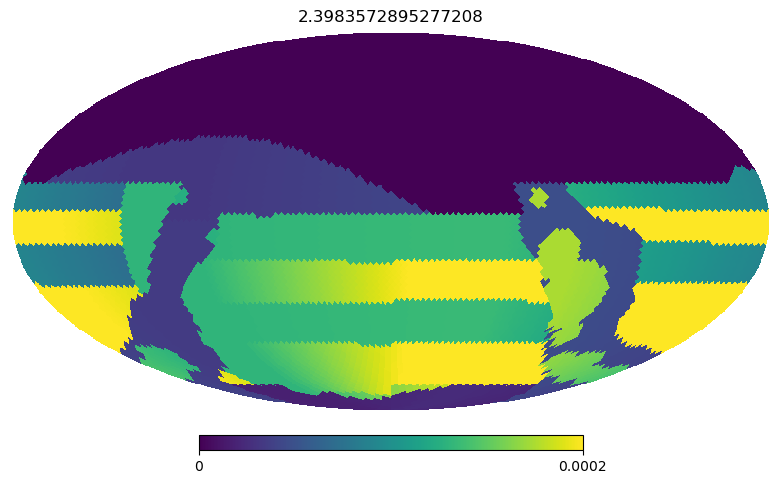

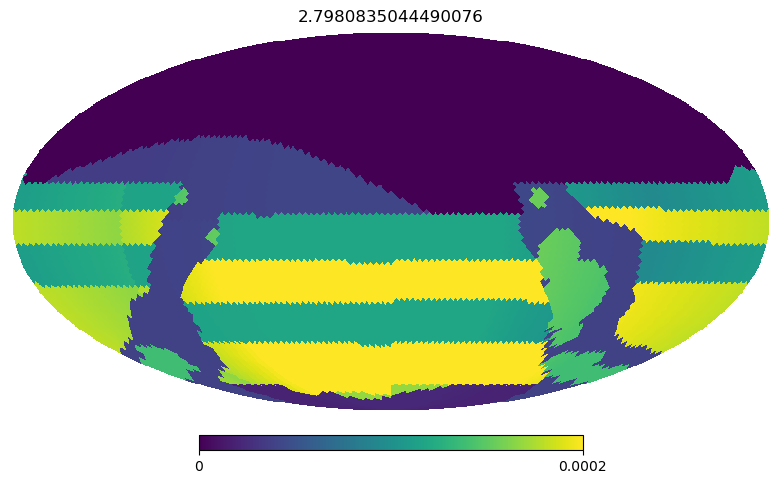

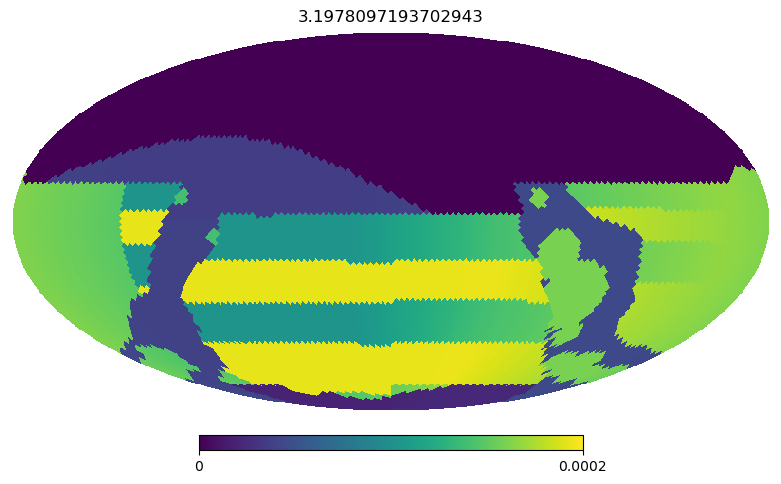

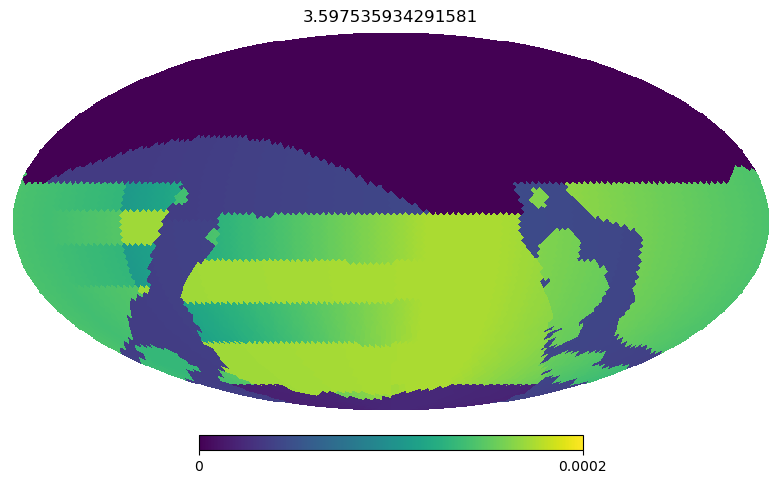

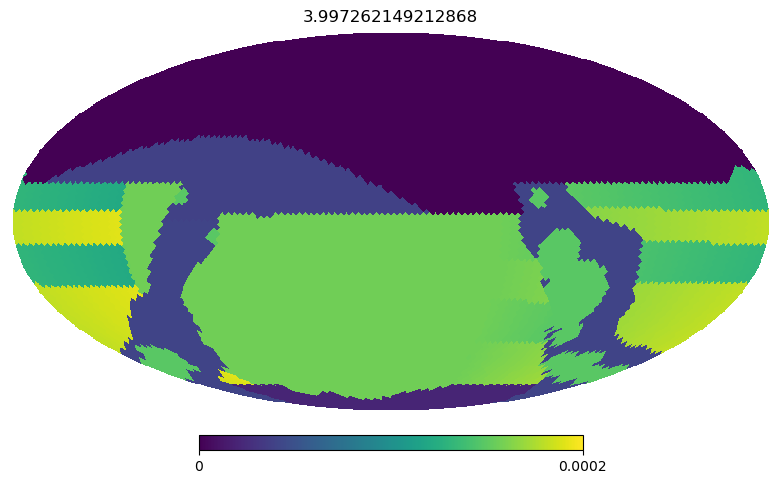

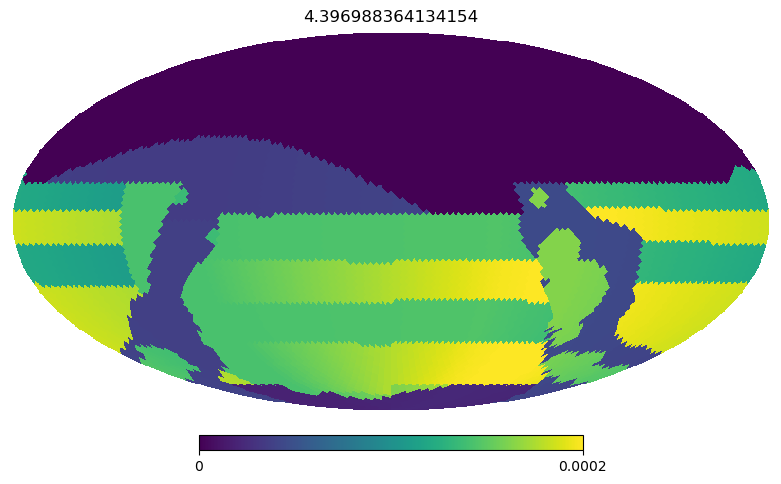

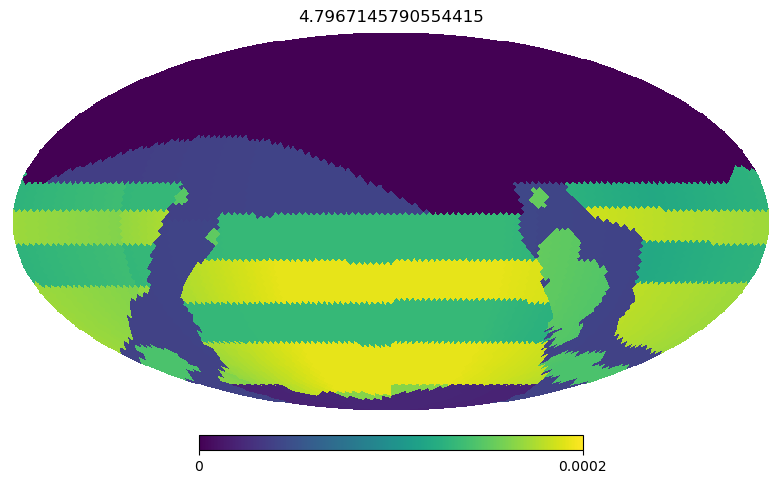

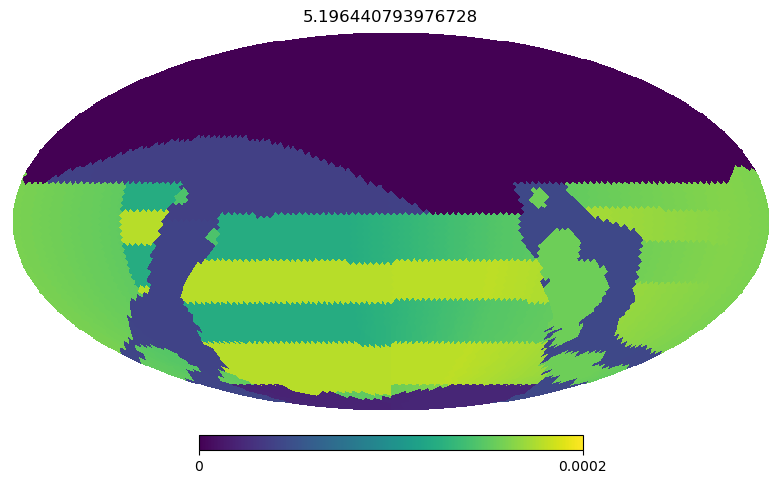

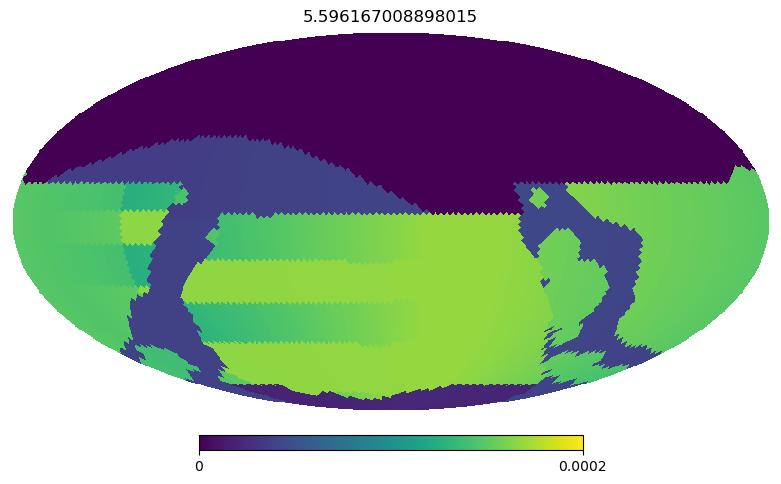

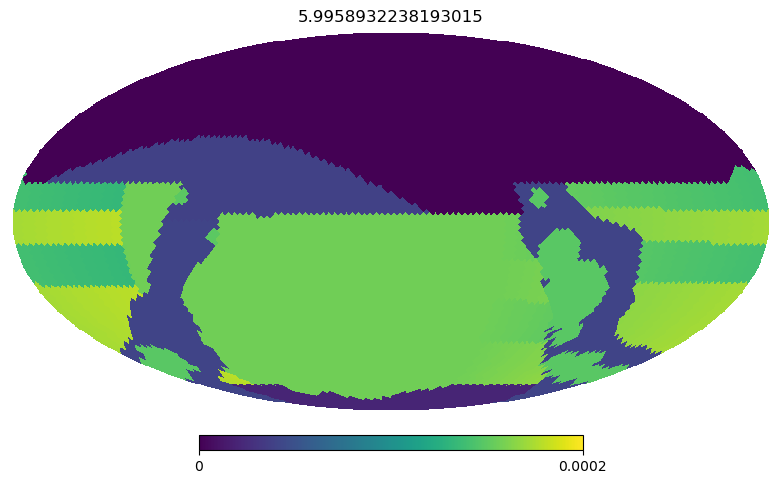

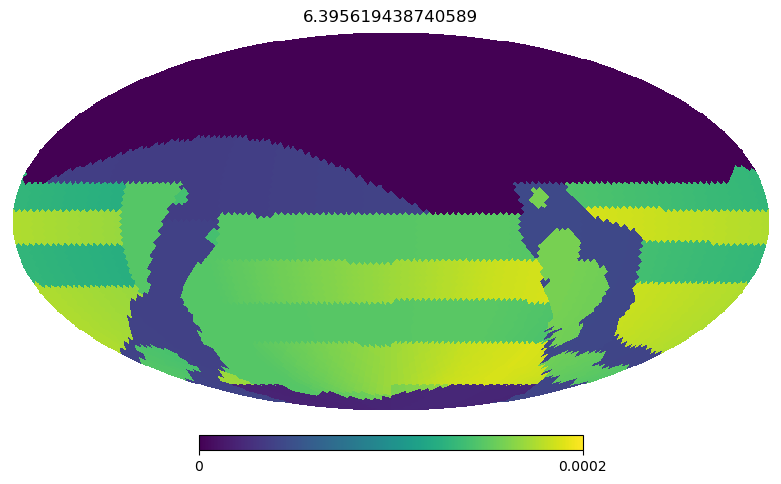

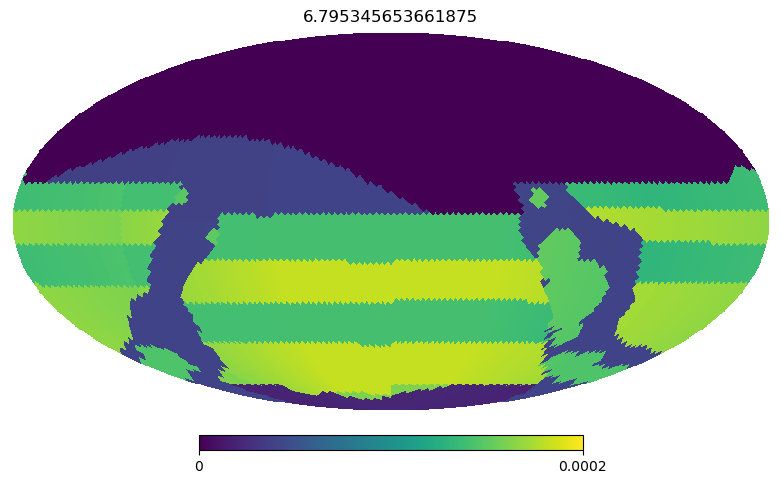

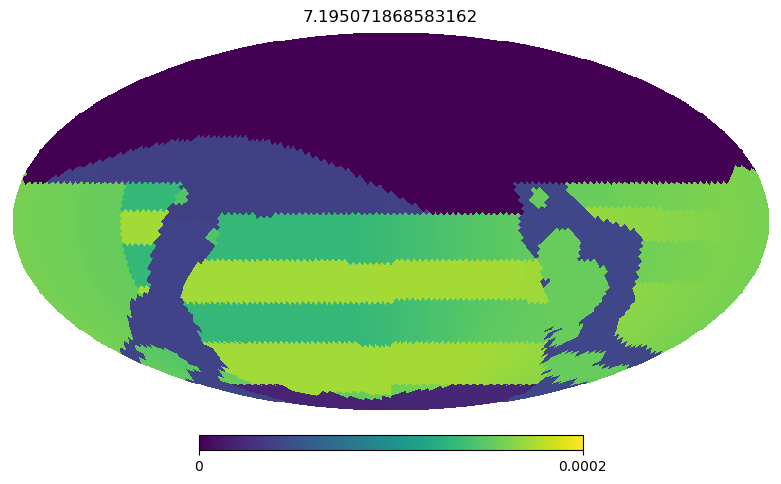

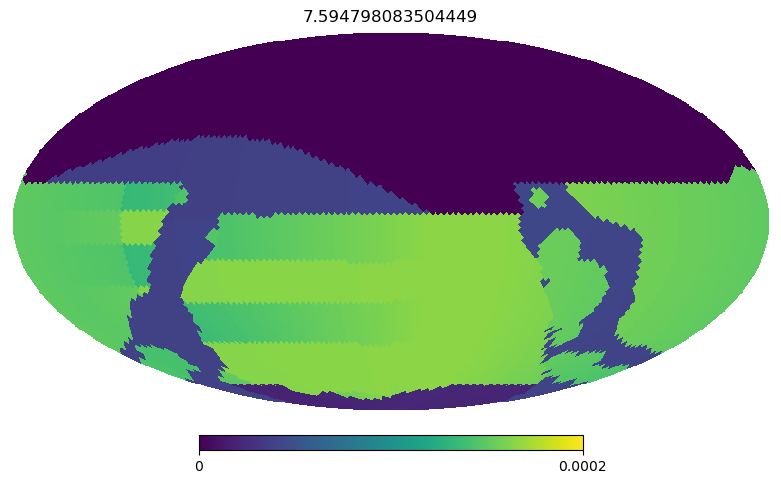

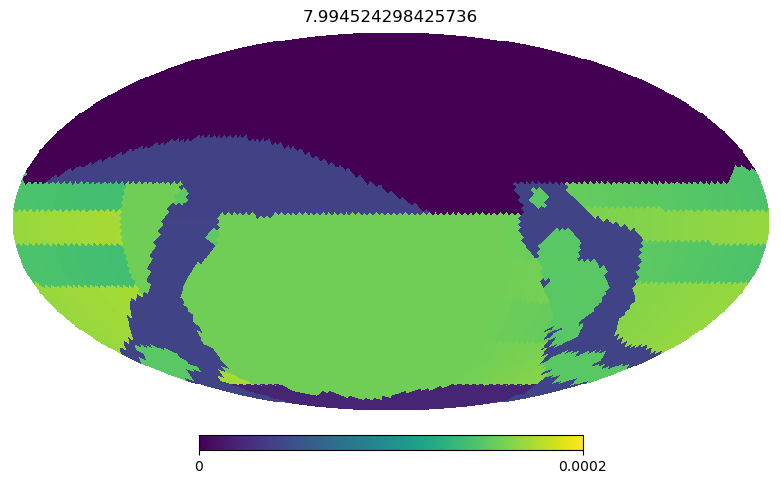

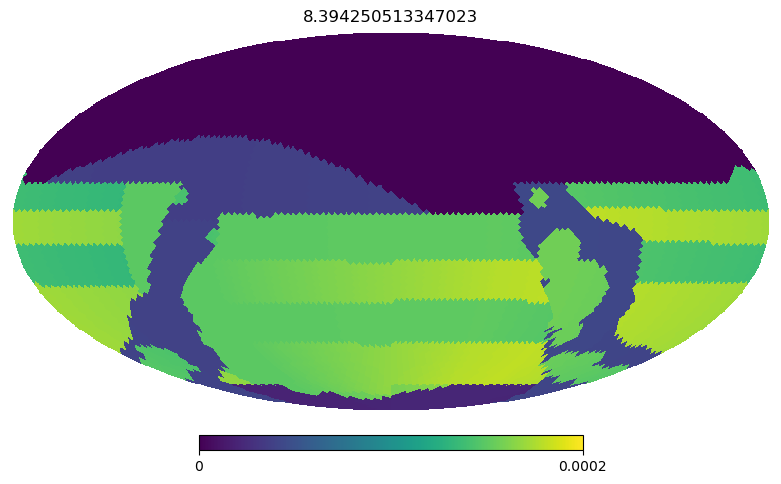

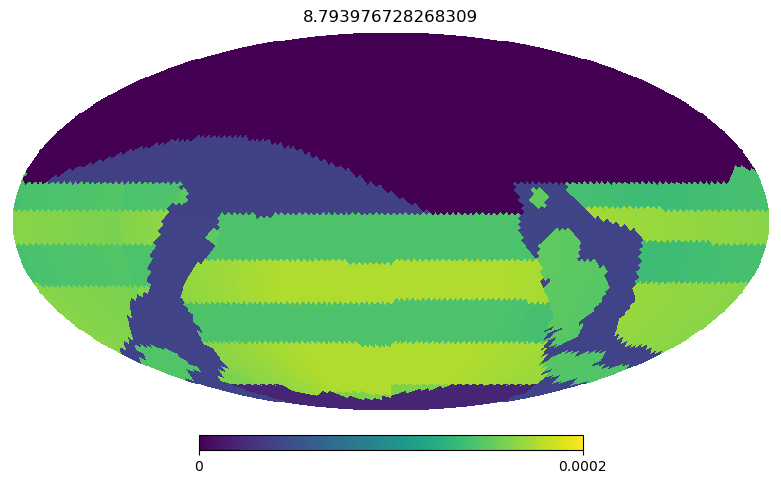

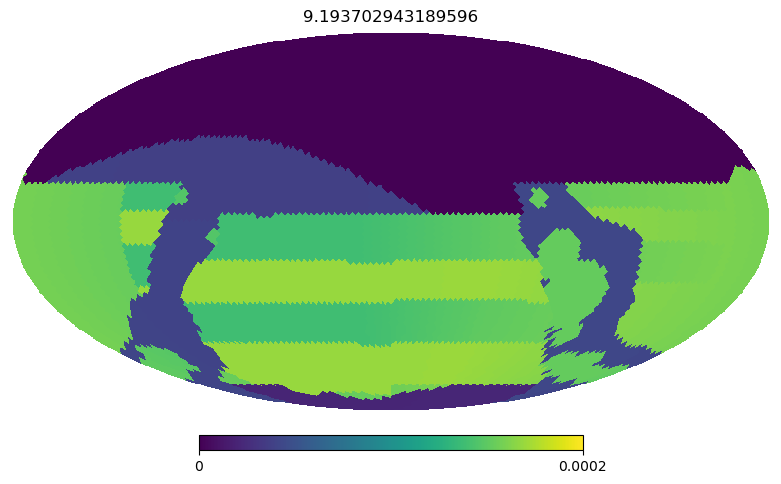

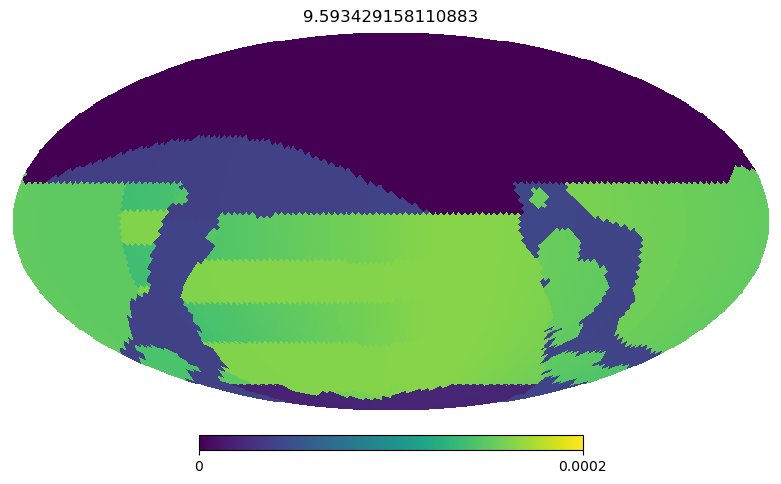

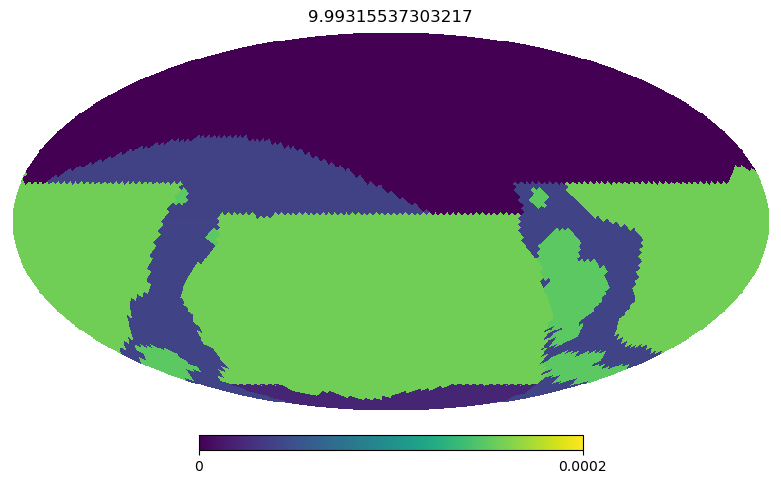

In [9]:
i = 0
for mjd in np.arange(mjd_start, mjd_start+3650+30, 365/2.5):
    map = sum_all_filters(footprints(mjd))
    fig = plt.figure(figsize=(8,5))
    hp.mollview(map, title=(mjd - mjd_start) / 365.25, fig=fig, max=2e-4)
    #plt.savefig(f"movie/rolling_footprint_{i :03d}.png", format='png')
    #plt.close()
    i += 1